Let's do a simple greenscreen replacement with a machine-learning model.

We will:
- download and display an image
- pre-process the pixels, labeling background and foreground pixels
- train a model to identify green background pixels
- use the predictions of the model swap the green screen background for an image of a forest

In [2]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/greenML.png

--2020-11-15 15:35:16--  https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/greenML.png
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/greenML.png [following]
--2020-11-15 15:35:16--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/greenML.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1190198 (1.1M) [image/png]
Saving to: ‘greenML.png’

greenML.png         100%[===================>]   1.13M  --.-KB/s    in 0.08s   

2020-11-15 15:35:17 (13.7 MB/s) - ‘greenML.png’ saved [1190198/1190198]



Here we download and display the image.

Using TensorFlow backend.


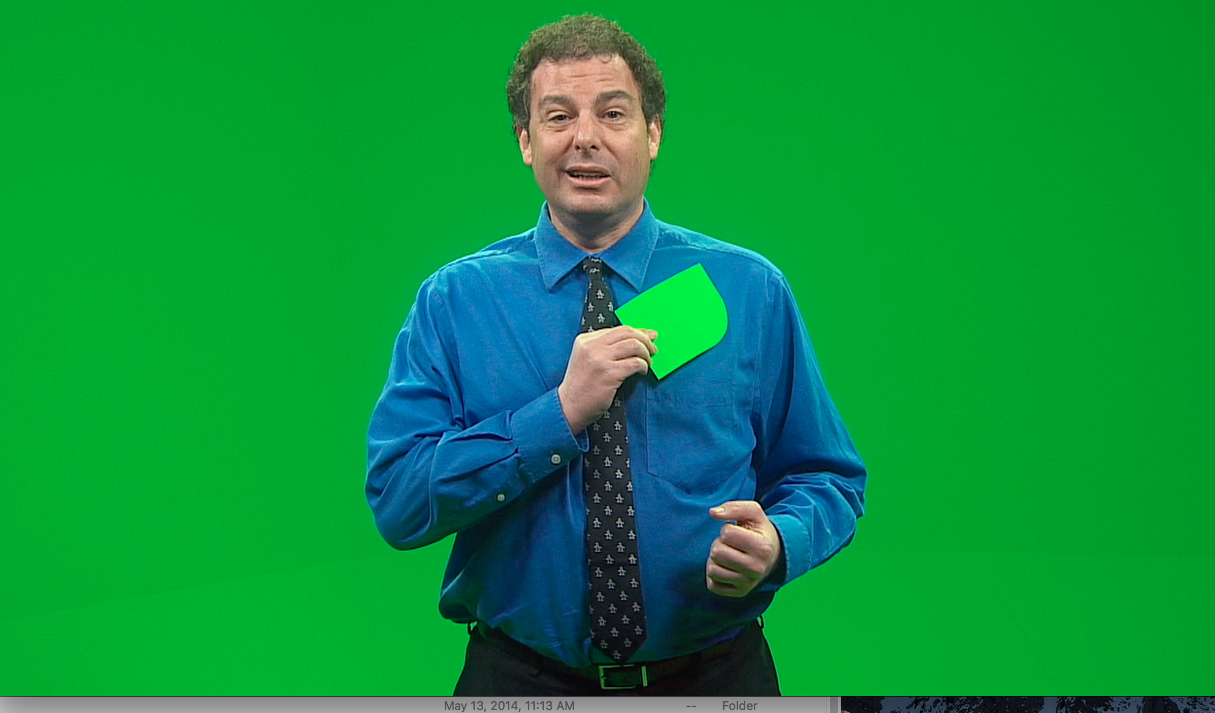

In [ ]:
import numpy as np
from keras.preprocessing import image

img = image.load_img("greenML.png")

display(img)

Below we trim the edges of the image.

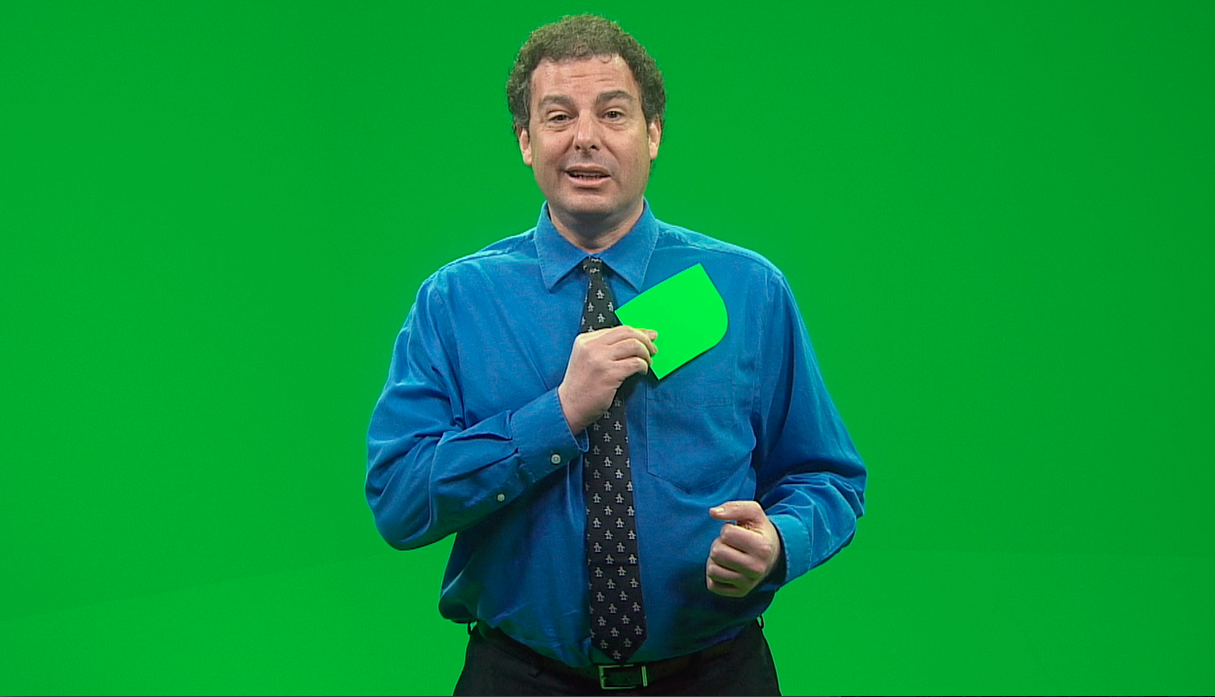

In [ ]:
arr = image.img_to_array(img)
# Trim off edges
arr = arr[:697,:]
display(image.array_to_img(arr,scale=False))

In this example, we isolate out the bacground and convert it to a dataset of positive examples, `yesList`.

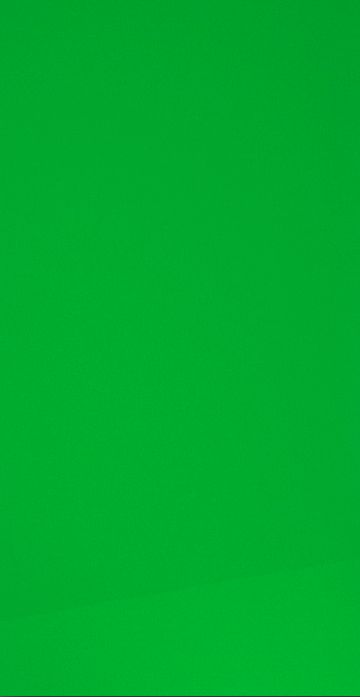

In [ ]:
# background
tmp = arr[:,:360]
display(image.array_to_img(tmp,scale=False))

yesList = np.reshape(tmp,(-1,3))

Below we print the number of values in each dimension of `tmp`.

In [ ]:
tmp.shape

(697, 360, 3)

Below we print the number of values in each dimension of `yesList`.

In [ ]:
yesList.shape

(250920, 3)

Below we build `seen` dictionary of the unique pixel colors in `yesList`.  For all keys in the dictionary, the value is 1.

In [ ]:
seen = {}
for c in yesList:
  col = str(c)
  if col not in seen: seen[col] = 1
len(seen)

306

Now we'll isolate out the foreground and make a dataset of foreground pixels called `noList`.

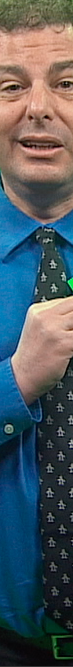

In [ ]:
# foreground
tmp = arr[30:,547:620]
display(image.array_to_img(tmp,scale=False))

noList = np.reshape(tmp,(-1,3))

Below is the number of values in each dimension of the full image, corresponding to the height, width, and RGB (red, green, blue) colors.

In [ ]:
arr.shape

(697, 1215, 3)

We finalize our dataset here, with a variable `alldat` which cointains our list of pixels, and `labs` which is our list of labels for each pixel, `0` for green background pixels and `1` for foreground pixels

In [ ]:
# Build a list of pixels for both positive and negative examples.
alldat = np.concatenate((yesList,noList))
 
# labels
labs = np.concatenate((np.ones(len(yesList)), np.zeros(len(noList))))

Here, we'll build a classifier to separate the background from the foreground

We define a `loss` function.  The `loss` takes in our data, `alldat`, our labels `labs`, and our current weights, `w`.  We will make adjustments to `w` based on this loss function.  To make a prediction, we will multiply `w` by `alldat`, and pass it through a sigmoid function to get our predictions, `y`.  We will then compare our predictions `y` to their true labels `labs` using a squared loss, the sum of the squared difference between `labs`, our true labels, and `y` our predicted values

In [ ]:
# Add an additional column to the data corresponding to 
#  the offset parameter.
alldat = np.concatenate((alldat,np.ones((len(alldat),1))),1)

# Compute the loss of the rule specified by weights w with respect
#  to the data alldat labeled with labs
def loss(w, alldat, labs):
  # Compute a weighted sum for each instance
  h = np.matmul(alldat,w)
  # transform the sum using the sigmoid function
  y = 1/(1 + np.exp(-h))
  # take the difference between the labels and the output of the 
  #  sigmoid, squared, then sum up over all instances to get the 
  #  total loss.
  loss = np.sum((labs - y)**2)
  return(loss)

To see how our `loss` function works, we'll print ou the loss of 10 random sets of weights

In [ ]:
# repeat 10 times
for i in range(10):
  # pick a random vector of weights, with values between -1 and 1
  w = np.random.random(4)*2-1
  # report the loss
  print(w, loss(w, alldat, labs))

[-0.22135533 -0.65228222 -0.26430745  0.90259811] 250926.79913526663
[ 0.43044719  0.22025946 -0.10055104 -0.05152583] 47608.62828326455
[ 0.48872867 -0.43453152 -0.18040086 -0.13776089] 263877.0073331105
[0.71389493 0.2716235  0.70094104 0.14995542] 48674.71379936311
[ 0.11819184 -0.7492165   0.22893221 -0.82912684] 250977.6236229302
[-0.62723409 -0.28199026  0.12193815 -0.82447237] 250985.02766269597
[-0.71568722  0.82153521 -0.94238905 -0.36418878] 1355.856347154657
[-0.28191066  0.81416143 -0.53483603 -0.32625155] 13519.923964598962
[-0.40253567  0.52175497  0.54742818  0.58094482] 48546.98472904646
[ 0.12608312 -0.49688863  0.02284923  0.96250856] 251017.12330771575


Now we'll train the model, by creating a `fit` function to fit the model to the data.  We will update the weights through gradient descent. 

In [ ]:
def fit(w,alldat,labs):
  # alpha represents how big of a step we’ll
  #  be taking in the direction of the derivative.
  #  It’s called the learning rate.
  alpha = 0.1

  # We'll stop searching when we're at a (near) local min
  done = False
  while not done:
    # Every 100 iterations or so, let’s
    #  take a peek at the weights, the learning
    #  rate, and the current loss
    if np.random.random() < 0.01: print(w, alpha, loss(w,alldat,labs))
    # The next few lines compute the gradient
    #  of the loss function. The details aren’t
    #  important right now.
    # delta_w is the change in the weights
    #  suggested by the gradient
    h = np.matmul(alldat,w)
    y = 1/(1 + np.exp(-h))
#    delta_w = np.add.reduce(np.reshape((labs-y) * np.exp(-h)/(1 + np.exp(-h))**2,(len(y),1)) * alldat)
    delta_w = np.add.reduce(np.reshape((labs-y) * np.exp(-h)*y**2,(len(y),1)) * alldat)
    # if we take a step of size alpha and update
    #  the weights, we’ll get new weights neww.
    current_loss = loss(w,alldat,labs)
    alpha *= 2
    neww = w + alpha* delta_w
    while loss(neww,alldat,labs) >= current_loss and not done:
      alpha /= 2
      if alpha*max(abs(delta_w)) < 0.0001: 
        done = True
        print(alpha,delta_w)
      else: neww = w + alpha* delta_w
    if not done: w = neww
  return(w)

# w = fit([-2.0, 0, 0.093, -0.713],alldat,labs)

w = [ 0.786,  0.175, -0.558, -0.437]
w = fit(w,alldat,labs)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


[-0.15425556  0.30151628 -0.89560813 -0.48402161] 4.8828125e-05 490.22612257101724
[-0.20204214  0.29569955 -0.86627475 -0.50485106] 4.8828125e-05 485.3712657021883
[-0.22891657  0.28851771 -0.84700584 -0.51842979] 2.44140625e-05 482.5066503523176
[-0.30480347  0.26613576 -0.77713622 -0.56255889] 4.8828125e-05 474.41519009385394
[-0.38746212  0.23288688 -0.67527474 -0.61925533] 2.44140625e-05 463.9296265744695
[-0.40521243  0.22434486 -0.64973896 -0.63275259] 2.44140625e-05 461.3479954277338
[-0.51774967  0.16716002 -0.46790716 -0.73703272] 1.220703125e-05 444.6932513018852
[-0.53476742  0.15938697 -0.44123141 -0.75747308] 1.220703125e-05 442.5835528364737
[-0.55035961  0.15195614 -0.41803741 -0.77774892] 1.220703125e-05 440.75353897746396
[-0.56216625  0.14690915 -0.40095066 -0.79415084] 1.220703125e-05 439.4739980153639
[-0.56697999  0.14508453 -0.39404121 -0.80110984] 1.220703125e-05 438.93614400542606
[-0.58078658  0.14041968 -0.37436429 -0.82197644] 1.220703125e-05 437.46412293510

We'll now print the final `loss` 

In [ ]:
print(loss([-0.138, -1.62, -1.00, -1.00], alldat, labs))
print(loss(w, alldat, labs))


250920.1982577528
404.56160879116885


These are the weights of our learned classifier

In [ ]:
w

array([-0.92246276,  0.11226589, -0.24727034, -2.04819454])

Now we'll display the predictions of the classifier for each pixel in our image.  We reshape our image, `arr` and multiply it by our learned weights, `w` to get our predictions for each pixel belonging to the background, `out`.  We convert `out` into a binary array and reshape to display as an image; `newarr` is our binarized prediction image.

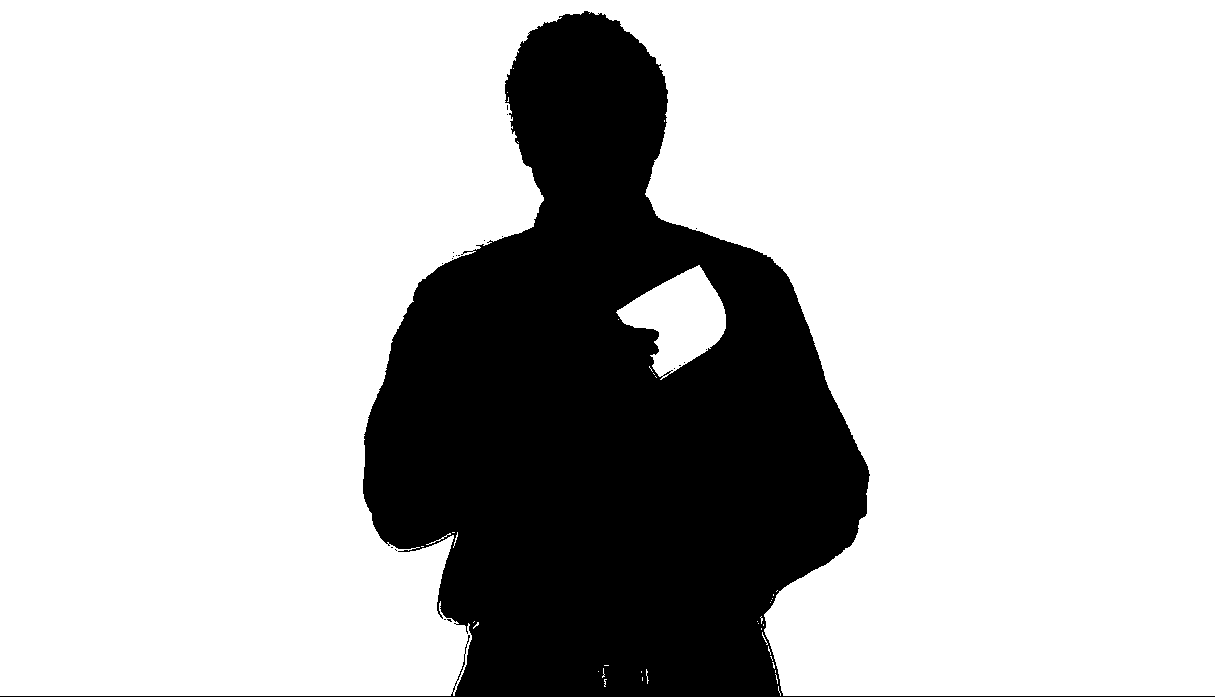

In [ ]:
# Turn the pixels in the image into a list
flat = np.reshape(arr,(-1,3))
# Stick a "1" at the end of each color
flat = np.concatenate((flat,np.ones((len(flat),1))),1)
# Multiply by the pixels by the weight matrix,
#  and set a threshold of 0.
out = np.matmul(flat, w) > 0.0
# Reshape the output as a 2 dimensional list instead of 1 dimensional
out = np.reshape(out,(-1,1))
# Now, concatenate this list it itself three times to make something
#  like a color. Reshape the resulting list into the shape of the original
#  image.
newarr = np.reshape(np.concatenate((out, out, out),1),arr.shape)
# Display the image
display(image.array_to_img(newarr))

With this classifier, we can replace the background with a new image of a forest

We download the image below.

In [1]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/forest.jpg

--2020-11-15 15:35:05--  https://github.com/mlittmancs/great_courses_ml/raw/master/imgs/forest.jpg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/forest.jpg [following]
--2020-11-15 15:35:05--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/imgs/forest.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644548 (629K) [image/jpeg]
Saving to: ‘forest.jpg’

forest.jpg          100%[===================>] 629.44K  --.-KB/s    in 0.05s   

2020-11-15 15:35:05 (12.0 MB/s) - ‘forest.jpg’ saved [644548/644548]



We display the image of the forest, `img` below and covert the image into an array, `bkg`.

In [ ]:
img = image.load_img("forest.jpg")

display(img)

bkg = image.img_to_array(img)

Output hidden; open in https://colab.research.google.com to view.

`composite` creates a new image based on a mask.  For each pixel in the new image:

- If the `mask` predicts the pixel to be in the background, we include the corresponding pixel from `background`.  
- If the `mask` predicts predicts the pixel to be in the foreground, we include the corresponding pixel from the `foreground`

We then display the `composite` of our prediction mask, `newarr`, the original photo, `arr`, and our forest image, `bkg`.

In [ ]:
def composite(mask, foreground, background):
  ishift = 157
  print(mask.shape)
  for i in range(min(background.shape[0],foreground.shape[0]+ishift)):
    for j in range(min(background.shape[1], foreground.shape[1])):
      fgi = i - ishift
#      if not mask[i][j][0]: background[i][j] = foreground[i][j]
      if fgi >= 0 and not mask[fgi][j][0]: background[i][j] = foreground[fgi][j]
  display(image.array_to_img(background,scale=False))

composite(newarr,arr,bkg)

Output hidden; open in https://colab.research.google.com to view.